## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
from IPython.display import clear_output
from statistics import mean

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [5]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [66]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [67]:
len(train_loader)

469

In [8]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


In [9]:
for test_img, test_label in test_loader:
    print(test_img.shape)
    print(test_label.shape)
    break

torch.Size([256, 1, 28, 28])
torch.Size([256])


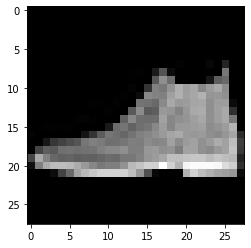

In [10]:
plt.imshow(test_img.cpu().detach().numpy()[0][0], cmap='gray')

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [68]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [69]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
         LeakyReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
         LeakyReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 64]          16,448
         LeakyReLU-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
         LeakyReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
       LogSoftmax-11                   [-1, 10]               0
Total params: 552,106
Trainable params: 552,106
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Your experiments come here:

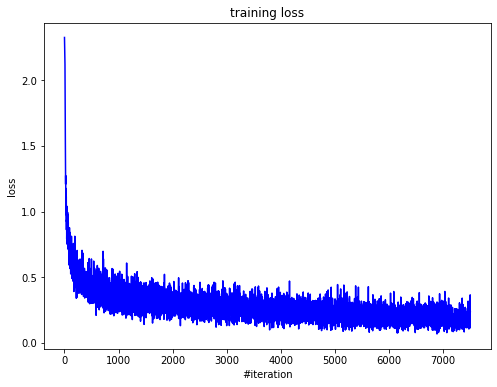

current loss: 0.236514


In [70]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()

# Your experiments, training and validation loops here
n_epoch = 16
loss_history = []

for epoch in range(n_epoch):
    for x_train, y_train in train_loader:
        opt.zero_grad()
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        
        pred = model.forward(x_train)
        loss_value = loss_func(pred, y_train)
        loss_history.append(loss_value)
        loss_value.backward()
        opt.step()

    clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title('training loss')
    plt.xlabel('#iteration')
    plt.ylabel('loss')
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('current loss: %f' % loss_value)

In [71]:
def compute_accuracy_from_tensors(y_true_tensor, y_pred_tensor):
    y_true_numpy = y_true_tensor.cpu().detach().numpy()[:, None]
    encoder = OneHotEncoder()
    encoder.fit(np.arange(10)[:, None])
    y_pred_decoded = encoder.inverse_transform(y_pred_tensor.cpu().detach().numpy())
    return accuracy_score(y_true_numpy, y_pred_decoded)

In [72]:
def compute_average_accuracy(model):
    accuracy_list = []
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        
        test_pred = model.forward(x_test)
        accuracy_list.append(compute_accuracy_from_tensors(y_test, test_pred))
        
    print('accuracy score on all test data is: ', mean(accuracy_list))

In [73]:
compute_average_accuracy(model)

accuracy score on all test data is:  0.89443359375


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [15]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [16]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
         LeakyReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
         LeakyReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 64]          16,448
         LeakyReLU-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
         LeakyReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
       LogSoftmax-11                   [-1, 10]               0
Total params: 552,106
Trainable params: 552,106
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [41]:
len(fmnist_dataset_train)

60000

In [56]:
fmnist_dataset_train_cut, _ = torch.utils.data.random_split(fmnist_dataset_train, [5000, 55000])

In [42]:
len(fmnist_dataset_test)

10000

In [77]:
train_loader_cutted = torch.utils.data.DataLoader(fmnist_dataset_train_cut, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [58]:
for x_test, y_test in test_loader:
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    break

In [59]:
x_test.shape

torch.Size([256, 1, 28, 28])

In [60]:
def plot_history(train_history, test_history, name):
    plt.figure(figsize=(8, 6))
    plt.title(name)
    plt.xlabel('#iteration')
    plt.ylabel(name)
    plt.plot(train_history, 'b', label='train')
    plt.plot(test_history, 'g', label='test')
    plt.legend()
    plt.show()

In [79]:
def run_experiment(model, n_epoch):
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_func = torch.nn.CrossEntropyLoss()

    train_loss_history = []
    test_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []

    for epoch in range(n_epoch):
        for x_train, y_train in train_loader_cutted:
            opt.zero_grad()
            x_train = x_train.to(device)
            y_train = y_train.to(device)

            #train
            train_pred = model.forward(x_train)
            train_loss_value = loss_func(train_pred, y_train)
            train_loss_history.append(train_loss_value)
            train_accuracy_history.append(compute_accuracy_from_tensors(y_train, train_pred))
            train_loss_value.backward()
            opt.step()
            
            #test
            test_pred = model.forward(x_test)
            test_loss_value = loss_func(test_pred, y_test)                
            test_loss_history.append(test_loss_value)
            test_accuracy_history.append(compute_accuracy_from_tensors(y_test, test_pred))                
            

        clear_output(wait=True)
        plot_history(train_loss_history, test_loss_history, 'loss')
        plot_history(train_accuracy_history, test_accuracy_history, 'accuracy')

        print('current train loss: %f' % train_loss_value)
        print('current test loss: %f' % test_loss_value)
        print('current train accuracy score: ', train_accuracy_history[-1])
        print('current test accuracy score: ', test_accuracy_history[-1])

    compute_average_accuracy(model=model)

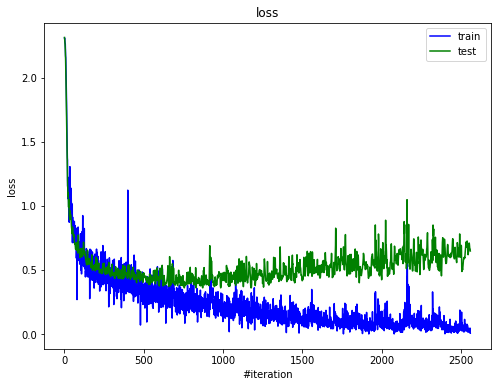

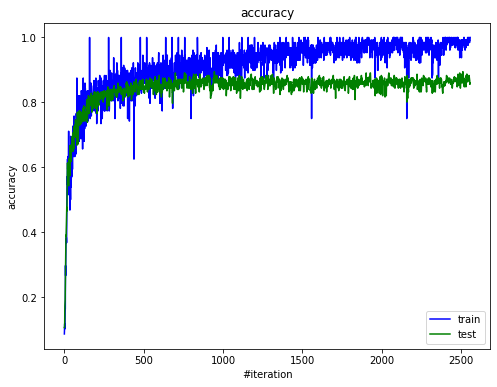

current train loss: 0.005837
current test loss: 0.647344
current accuracy score:  0.859375
accuracy score on all test data is:  0.84072265625


In [64]:
model = OverfittingNeuralNetwork().to(device)
run_experiment(model=model, n_epoch=64)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [103]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 64),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [104]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
           Dropout-3                  [-1, 512]               0
         LeakyReLU-4                  [-1, 512]               0
       BatchNorm1d-5                  [-1, 512]           1,024
            Linear-6                  [-1, 256]         131,328
         LeakyReLU-7                  [-1, 256]               0
       BatchNorm1d-8                  [-1, 256]             512
            Linear-9                   [-1, 64]          16,448
          Dropout-10                   [-1, 64]               0
        LeakyReLU-11                   [-1, 64]               0
      BatchNorm1d-12                   [-1, 64]             128
           Linear-13                   [-1, 32]           2,080
        LeakyReLU-14                   

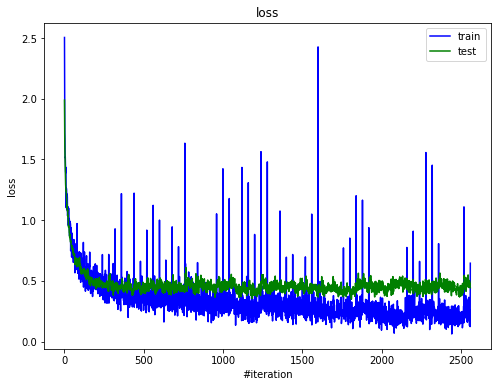

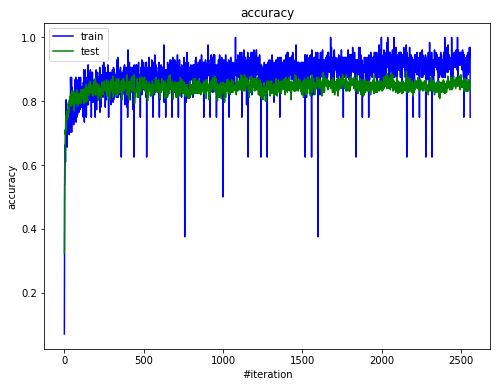

current train loss: 0.645158
current test loss: 0.443501
current train accuracy score:  0.75
current test accuracy score:  0.86328125
accuracy score on all test data is:  0.82998046875


In [105]:
model = FixedNeuralNetwork().to(device)
run_experiment(model=model, n_epoch=64)

In [96]:
# try without dropout
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 64),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [97]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
         LeakyReLU-3                  [-1, 512]               0
       BatchNorm1d-4                  [-1, 512]           1,024
            Linear-5                  [-1, 256]         131,328
         LeakyReLU-6                  [-1, 256]               0
       BatchNorm1d-7                  [-1, 256]             512
            Linear-8                   [-1, 64]          16,448
         LeakyReLU-9                   [-1, 64]               0
      BatchNorm1d-10                   [-1, 64]             128
           Linear-11                   [-1, 32]           2,080
        LeakyReLU-12                   [-1, 32]               0
      BatchNorm1d-13                   [-1, 32]              64
           Linear-14                   

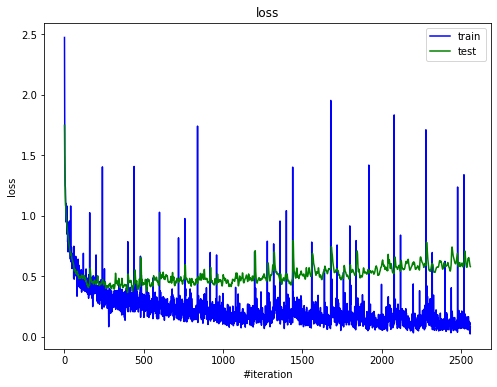

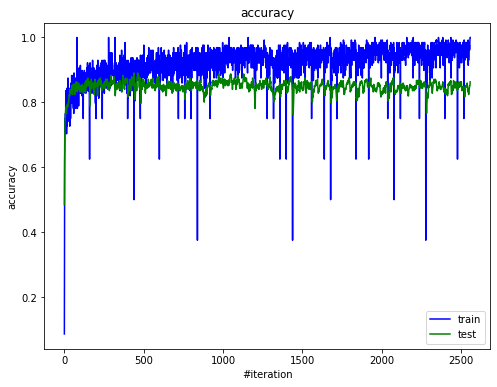

current train loss: 0.080500
current test loss: 0.578441
current train accuracy score:  1.0
current test accuracy score:  0.86328125
accuracy score on all test data is:  0.83671875


In [98]:
model = FixedNeuralNetwork().to(device)
run_experiment(model=model, n_epoch=64)

In [100]:
# try without batchnorm
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 64),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [101]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
           Dropout-3                  [-1, 512]               0
         LeakyReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
         LeakyReLU-6                  [-1, 256]               0
            Linear-7                   [-1, 64]          16,448
           Dropout-8                   [-1, 64]               0
         LeakyReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 32]           2,080
        LeakyReLU-11                   [-1, 32]               0
           Linear-12                   [-1, 10]             330
       LogSoftmax-13                   [-1, 10]               0
Total params: 552,106
Trainable params:

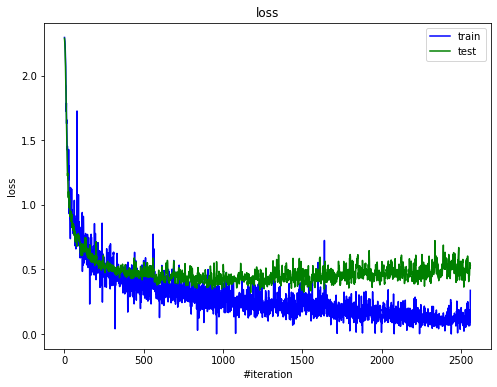

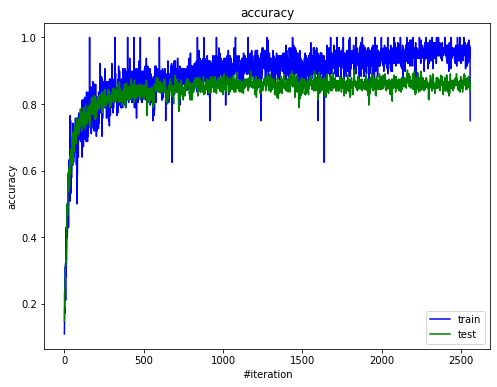

current train loss: 0.337886
current test loss: 0.529435
current train accuracy score:  0.75
current test accuracy score:  0.85546875
accuracy score on all test data is:  0.82265625


In [102]:
model = FixedNeuralNetwork().to(device)
run_experiment(model=model, n_epoch=64)

### Conclusions:
_Write down small report with your conclusions and your ideas._

Batchnorm and Dropout a really effective technics to fight overfitting.
The most significant impact accures if we apply dropout and batchnorm together.
Although the didn't really make accuracy score on all test data, it apparent that they decrease overfitting, as seen on the plots.